# Visual Inspection of Motorcycle Connecting Rods

This notebook exemplifies the working capability of a software system that performs a visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of different types of rods to help a vision-guided robot to pick and sort the rods based on their properties.

The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

Task objectives and challenges are differentiated in two different sections based on image characteristics:

1. **FIRST SECTION**: the images exhibit the following characteristics:
    - the images exclusively contain rod objects, which may vary in dimensions and features;
    - connecting rods are well-placed in the image, each is separated from the others (i.e., no contact points between objects);
    - images are captured using backlighting techniques to ensure that the rods are easily distinguishable from the background.
    
    For every rod present in the image, the vision system is expected to provide the following information:
    - rod type (A or B);
    - position and orientation (modulo $\pi$);
    - length, width and width at the barycenter;
    - for each hole the position of the centre and the diameter size.

    Images indexes: `00`, `01`, `12`, `21`, `31`, `33`. 
      
2. **SECOND SECTION**: images have the following characteristics:
    - images may contain objects other than rods that are not relevant for analysis by the system;
    - rods may exhibit contact points but do not overlap with one another;
    - the inspection are may be dirty due to the presence of scattered iron powder.

    The functional specifications remain the same of the first section.

    Images indexes: `44`, `47`, `48`, `49`, `50`, `51`, `90`, `92`, `98`.  



## Libraries and Data loading

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
%load_ext autoreload
%autoreload 2


sys.path.append(".")

## Data

Load the data from `./ispezione-bielle-immagini` folder.

In [2]:
data_folder = Path("ispezione-bielle-immagini")
task1_names = [
    "TESI00.BMP",
    "TESI01.BMP",
    "TESI12.BMP",
    "TESI21.BMP",
    "TESI31.BMP",
    "TESI33.BMP",
]

task2_names = [
    "TESI44.BMP",
    "TESI47.BMP",
    "TESI48.BMP",
    "TESI49.BMP",
    "TESI50.BMP",
    "TESI51.BMP",
    "TESI90.BMP",
    "TESI92.BMP",
    "TESI98.BMP",
]

paths_1 = []
paths_2 = []
for _path in data_folder.rglob("*.BMP"):
    if _path.name.upper() in task1_names:
        paths_1.append(_path)
    elif _path.name.upper() in task2_names:
        paths_2.append(_path)

# Load the images
images_1 = [cv2.imread(str(_path), cv2.IMREAD_GRAYSCALE) for _path in paths_1]
images_2 = [cv2.imread(str(_path), cv2.IMREAD_GRAYSCALE) for _path in paths_2]


Let's visualize the images of the first section:

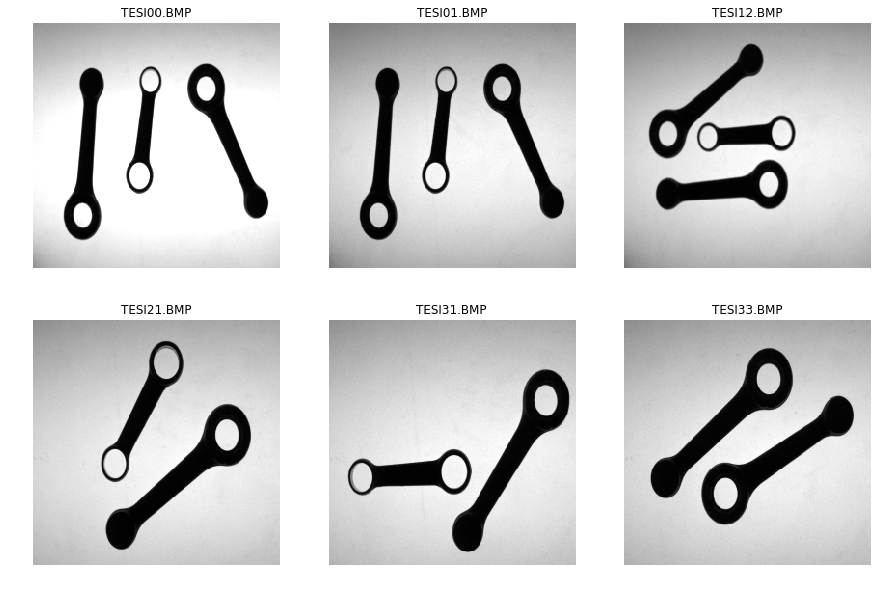

In [3]:
# Print the images in a grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, (img, path) in enumerate(zip(images_1, paths_1)):
    axs[i // 3, i % 3].imshow(img, cmap="gray")
    axs[i // 3, i % 3].set_title(path.name)
    axs[i // 3, i % 3].axis("off")
plt.show()


And the second section:

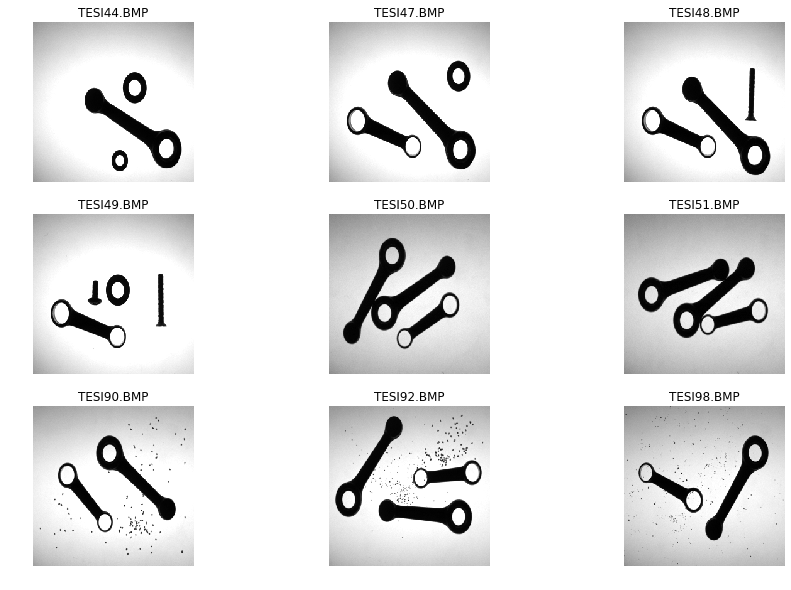

In [4]:
# Print the images in a grid
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, (img, path) in enumerate(zip(images_2, paths_2)):
    axs[i // 3, i % 3].imshow(img, cmap="gray")
    axs[i // 3, i % 3].set_title(path.name)
    axs[i // 3, i % 3].axis("off")
plt.show()


## First section

**Functional specifications**
For each connecting rod appearing in the image, the vision system should provide the following information:
1. Type of rod (A or B).
2. Position and orientation (modulo $\pi$).
3. Length, width and width at the barycenter.
4. For each hole, position of the centre and diameter size.

***

The higher-level function is contained in `src/rod_detection.py` file. The `detect_rods_blob` method takes as input the image and a dictionary containing the salient information about them.

The function perform the following steps to meet the requirements:
1. Apply a gaussian filter to the image to reduce noise. The filter size is computed by the *rule-of-thumb* method and the $\sigma = 1$.
2. Binarize the image through a thresholding operation. By default, the method is set to `cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU`, which applies an adaptive thresholding operation that automatically determines the threshold value based on the image histogram.

![Original image vs. binary image](./images/notebook/bin_img.png)

3. To detect the different objects we decided to opt with the `opencv` method `connectedComponentsWithStats` that computed the connected components (CC) labeled of a binary image. This method returns the number of objects detected, the label matrix, some relative statistics and the centroids positions. The labels identify different CCs (0 identify the background). The statistics are a matrix of size $N \times 5$ where $N$ is the number of CCs. Each row contains the following information: [leftmost x coordinate, topmost y coordinate, width of the bounding box, height of the bounding box, total **area** (in pixels)].

4. For each CC we initially find the contours via the `cv2.findContours` method. It is noteworthy to say that the *contour retrieval mode* is set to `cv2.RETR_CCOMP` which returns a 2-level hierarchy of contours: the first level are the external contours of the objects, the second level are the contours of the holes. That is, the returned hierarchy `hierarchy[i]` contains the next contour (at the same level), the previous contour (at the same level), the first child contour and the parent contour. This means that to find holes we simply have to check if the contours has no child (`hierarchy[i][2] == -1`) and at least one parent (`hierarchy[i][3] > -1`). Since now th number of holes is easily computable we can identify the type of rod.

5. We then compute the minimum enclosing rectangle of the external contours by using the `opencv` function `minAreaRect` to obtain the length, width and angle of the rod. Since the angle of the method is always in the range $[-90, 0)$, we have to convert it to the range $[0, \pi)$  ([orientation-opencv](https://automaticaddison.com/how-to-determine-the-orientation-of-an-object-using-opencv/), [minAreaRect-angle](https://theailearner.com/tag/cv2-minarearect/))

6. To get the barycenter of the rod, or the CC, we simply compute the mass center $C$ of the external contours using the formula:
    $$
        C_x = \frac{M_{10}}{M_{00}};\,C_y = \frac{M_{01}}{M_{00}}
    $$
    where $M_{ij}$ are the already computed moments of the contours (using the `cv2.moments` method).

7. To compute the width at the barycenter we compute:
    - the major axis coefficients by computing the covariance matrix, and then the eigenvalues and eigenvectors of the covariance matrix. The major axis is the eigenvector associated with the largest eigenvalue;
    - the signed distance between any point lying on the major axis and the barycenter; points that have a negative distance are on the left side (`blue`) of the major axis, points that have a positive distance are on the right side of the major axis (`red`).
    - points with the minimum absolute distance from the mass center, or barycenter, are points that are farther away from the barycenter whilst being on the minor axis. The width at the barycenter is the distance between these two points.

8. Lastly we compute the position of the holes by computing the mass center of the contours of the holes. We also compute the diameter of the holes by using the `cv2.minEnclosingCircle` method which returns the radius of the minimum enclosing circle given a contour, in this case the internal ones.

We can see the output of the function for the 5th image of the first section:
    ![](./images/notebook/output_4.png)

- the fucsia line depicts the major axis of the rod;
- the purple line depicts the MER of the rod;
- the green circles depict the holes mass centers and the circle contour;
- the blue and red points depict the points on the minor axis that are farther away from the barycenter;

We can iterate over all the images to obtain for each rod the information described above and more. Images are then saved to the `./images/first/` folder.

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (201, 118)
INFO:root:Area (CC): 3227
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 169.35
INFO:root:Rod Width: 39.78
INFO:root:Rod Angle (deg): 110.40°
INFO:root:Rod mass center: (198, 113)
INFO:root:Width at mass center: 14.76
INFO:root:Hole mass center: [(179, 68)]
INFO:root:Hole diameter: [26.383808135986328]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  4.62it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (115, 113)
INFO:root:Area (CC): 1477
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 130.91
INFO:root:Rod Width: 26.89
INFO:root:Rod Angle (deg): 84.81°
INFO:root:Rod mass center: (115, 11

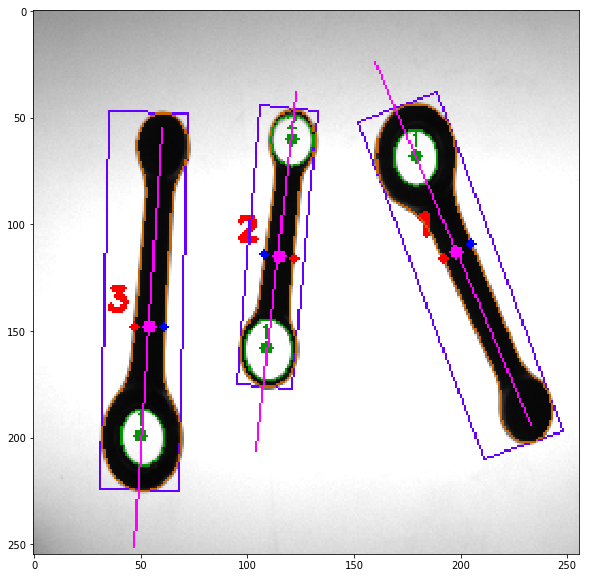

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (201, 118)
INFO:root:Area (CC): 3238
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 169.35
INFO:root:Rod Width: 39.88
INFO:root:Rod Angle (deg): 110.35°
INFO:root:Rod mass center: (198, 113)
INFO:root:Width at mass center: 14.76
INFO:root:Hole mass center: [(178, 68)]
INFO:root:Hole diameter: [26.383808135986328]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  3.27it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (115, 113)
INFO:root:Area (CC): 1484
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 131.01
INFO:root:Rod Width: 26.89
INFO:root:Rod Angle (deg): 84.81°
INFO:root:Rod mass center: (115, 11

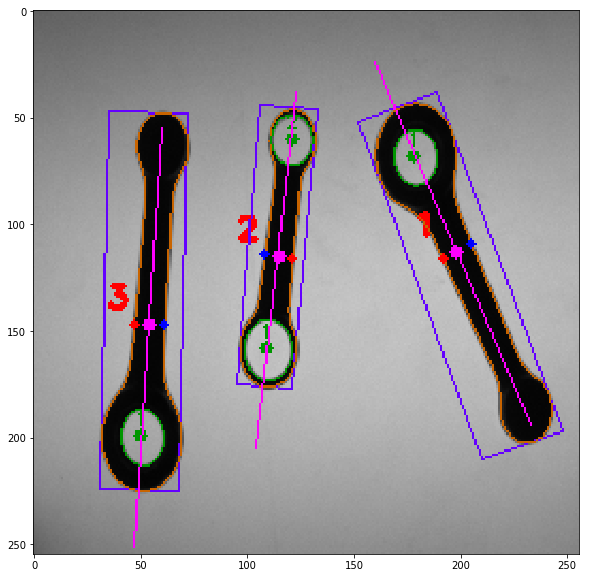

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (82, 81)
INFO:root:Area (CC): 3272
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 152.06
INFO:root:Rod Width: 43.81
INFO:root:Rod Angle (deg): 45.34°
INFO:root:Rod mass center: (78, 85)
INFO:root:Width at mass center: 17.03
INFO:root:Hole mass center: [(45, 115)]
INFO:root:Hole diameter: [27.29488754272461]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  4.65it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (128, 116)
INFO:root:Area (CC): 1447
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 100.11
INFO:root:Rod Width: 35.06
INFO:root:Rod Angle (deg): 0.74°
INFO:root:Rod mass center: (129, 116)
INFO

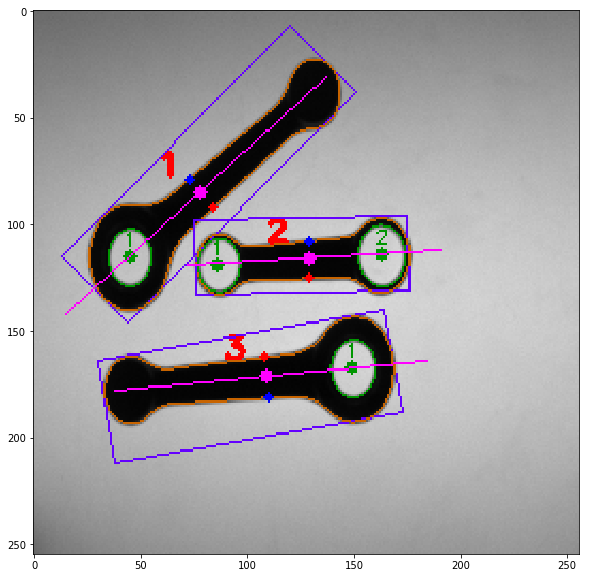

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (114, 90)
INFO:root:Area (CC): 2460
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 156.71
INFO:root:Rod Width: 37.40
INFO:root:Rod Angle (deg): 64.95°
INFO:root:Rod mass center: (114, 91)
INFO:root:Width at mass center: 1.00
INFO:root:Hole mass center: [(84, 149), (137, 45)]
INFO:root:Hole diameter: [31.591938018798828, 34.36587905883789]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (153, 162)
INFO:root:Area (CC): 5222
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 193.12
INFO:root:Rod Width: 55.77
INFO:root:Rod Angle (deg): 45.54°
INFO:root

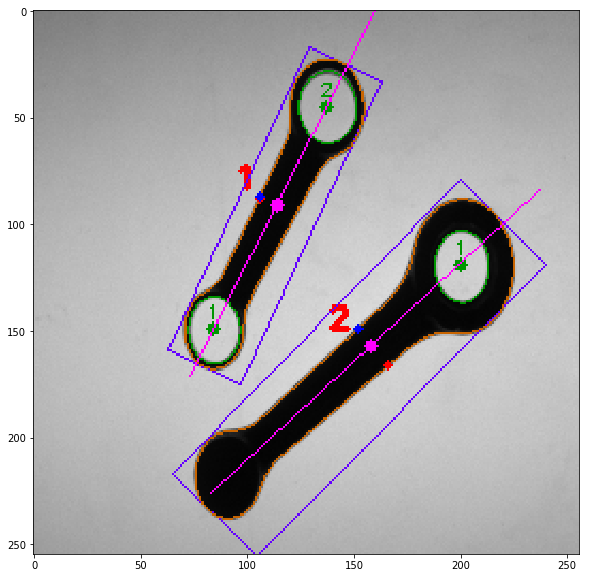

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (189, 142)
INFO:root:Area (CC): 5221
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 208.46
INFO:root:Rod Width: 51.68
INFO:root:Rod Angle (deg): 62.47°
INFO:root:Rod mass center: (193, 136)
INFO:root:Width at mass center: 20.25
INFO:root:Hole mass center: [(224, 83)]
INFO:root:Hole diameter: [33.3027229309082]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (85, 160)
INFO:root:Area (CC): 2396
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 126.15
INFO:root:Rod Width: 45.05
INFO:root:Rod Angle (deg): 0.60°
INFO:root:Rod mass center: (86, 160)
INF

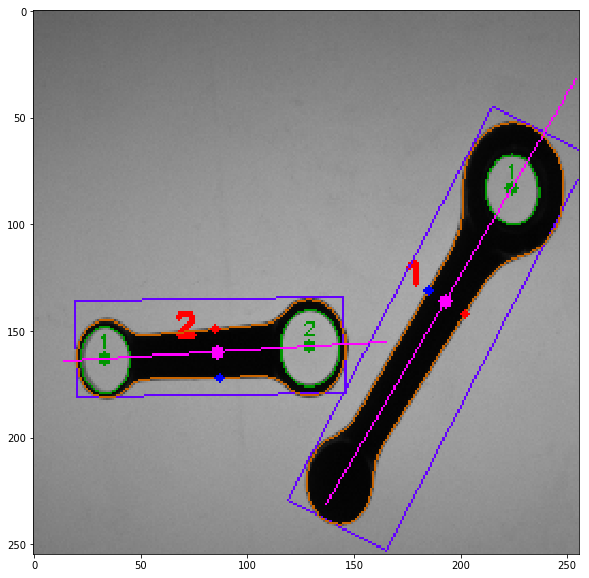

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (104, 105)
INFO:root:Area (CC): 5232
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 194.94
INFO:root:Rod Width: 55.50
INFO:root:Rod Angle (deg): 47.73°
INFO:root:Rod mass center: (109, 100)
INFO:root:Width at mass center: 22.67
INFO:root:Hole mass center: [(149, 61)]
INFO:root:Hole diameter: [33.302734375]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (154, 145)
INFO:root:Area (CC): 5188
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 187.09
INFO:root:Rod Width: 58.19
INFO:root:Rod Angle (deg): 38.98°
INFO:root:Rod mass center: (149, 149)
INFO

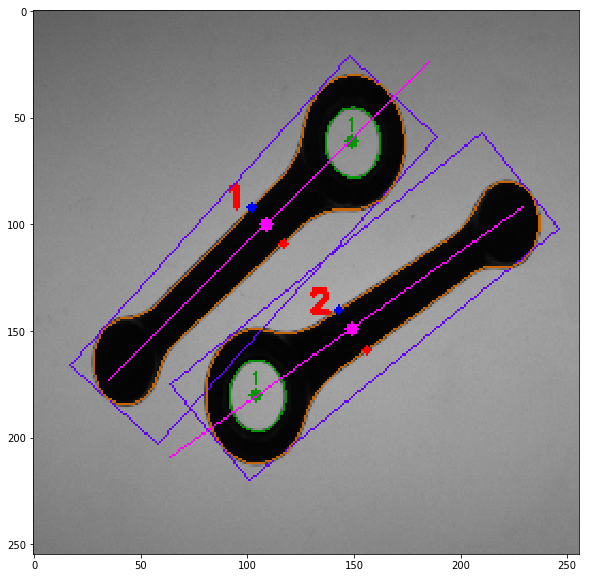

In [5]:
from src.rod_detection import detect_rods_blob

results = {}
for i in range(6):
    results[i] = detect_rods_blob(images_1[i], visualize=True)

## Second task

The functional specifications remain the same of the first section, but here we have additional challenges that we need to address specifically:
1. **Distractors**: we need to filter out the distractors from the image. To do so we can use the `cv2.connectedComponentsWithStats` method to find the connected components of the image. We can then filter out the distractors by using the area of the CCs. We can set a threshold on the area of the CCs to filter out the distractors. This is done by passing a `min_area` parameter to the `detect_rods_blob` method.
2. **Iron powder**: we need to find a way to filter out the iron powder from the image. This challenge is already solved by the `min_area` parameter that has to be carefully chosen in order to keep the rods but to filter out iron and distractors. We found the best value to be `min_area=1500`.
3. **Contact points**: to solve this challenge we have to separate the task in two main focal points: 
    1. **Contact points detection**: we iterate for every external contour, approximate it (with `cv2.approxPolyDP(epsilon=3, closed=True)`) and then compute the convex hull on the approximated contour. Then by using `cv2.convexityDefects` we can find the convexity defects of the contours (the convexity defects are the points where the contour is not convex). For each defect found we then count the non zero pixels in a small patch around the point, if the amount of non zero pixels is greater than a threshold (we set it to `18`) we can say that the point is a contact point. We can then draw the contact points on the image, like is done below with the two whiteish points.
    2. **Rods separation**: we can separate the rods by using the contact points. First and foremost we perform a dilation operation with a $2\times2$ kernel and a erosion operation with a $2\times1$ kernel. This operation is done to first dilate a bit the objects and then to try to remove small rectangular bridges between. The code then iterate over each pair of contact points and discard the one that are too far away from each other. We then draw a black line between the two points, this will separate the two rods in the binary image.

The rest of the code is the same as before, we can see the output of the function for the 5th image of the second section. 

![](./images/notebook/output_contact.png)

As before we can iterate over all the images to obtain for each rod the information described above and more. Images are then saved to the `./images/second/` folder.

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 1
Processing rods:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (161, 105)
INFO:root:Area (CC): 4918
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 181.64
INFO:root:Rod Width: 56.07
INFO:root:Rod Angle (deg): 141.91°
INFO:root:Rod mass center: (168, 173)
INFO:root:Width at mass center: 22.47
INFO:root:Hole mass center: [(212, 202)]
INFO:root:Hole diameter: [33.37683868408203]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


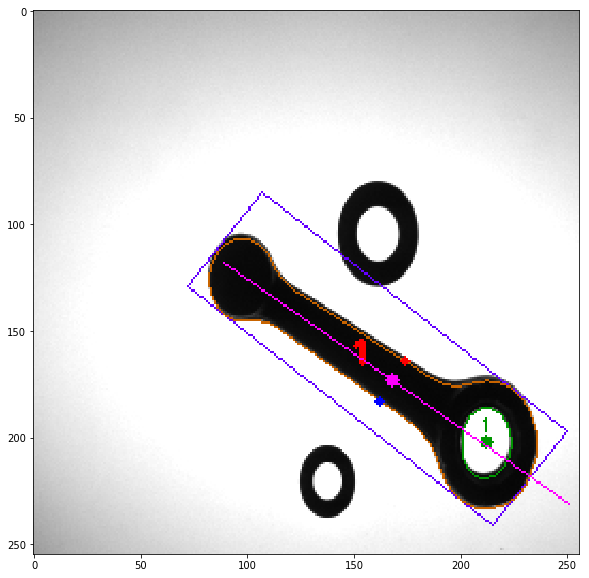

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (205, 87)
INFO:root:Area (CC): 4972
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 191.57
INFO:root:Rod Width: 53.33
INFO:root:Rod Angle (deg): 129.56°
INFO:root:Rod mass center: (170, 163)
INFO:root:Width at mass center: 21.26
INFO:root:Hole mass center: [(208, 204)]
INFO:root:Hole diameter: [33.37683868408203]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (166, 159)
INFO:root:Area (CC): 2273
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 129.24
INFO:root:Rod Width: 41.59
INFO:root:Rod Angle (deg): 153.43°

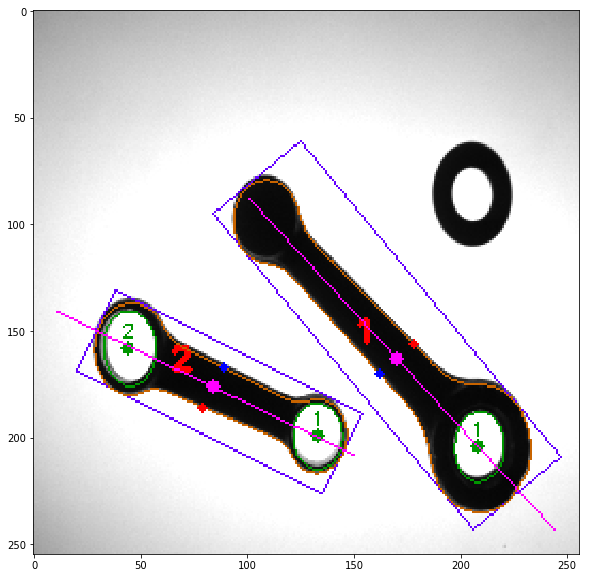

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (202, 117)
INFO:root:Area (CC): 4976
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 191.29
INFO:root:Rod Width: 53.63
INFO:root:Rod Angle (deg): 129.70°
INFO:root:Rod mass center: (169, 173)
INFO:root:Width at mass center: 21.21
INFO:root:Hole mass center: [(208, 213)]
INFO:root:Hole diameter: [33.241737365722656]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (165, 168)
INFO:root:Area (CC): 2265
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 129.33
INFO:root:Rod Width: 41.93
INFO:root:Rod Angle (deg): 152.4

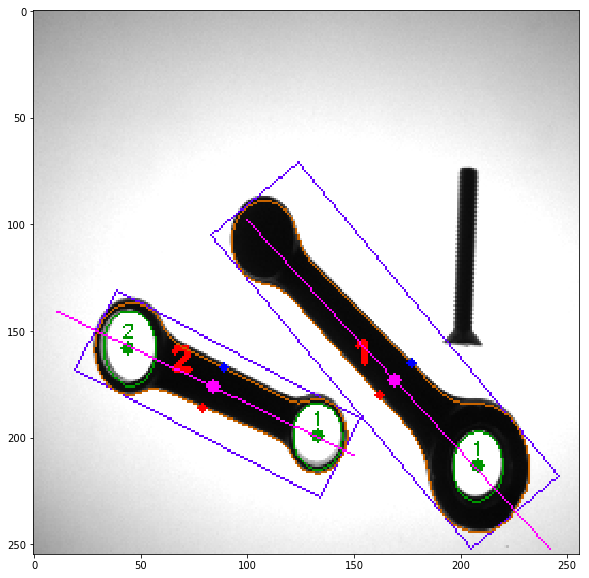

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 1
Processing rods:   0%|          | 0/1 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (203, 140)
INFO:root:Area (CC): 2311
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 128.75
INFO:root:Rod Width: 42.20
INFO:root:Rod Angle (deg): 154.77°
INFO:root:Rod mass center: (84, 175)
INFO:root:Width at mass center: 21.02
INFO:root:Hole mass center: [(133, 196), (44, 158)]
INFO:root:Hole diameter: [31.257200241088867, 35.525238037109375]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


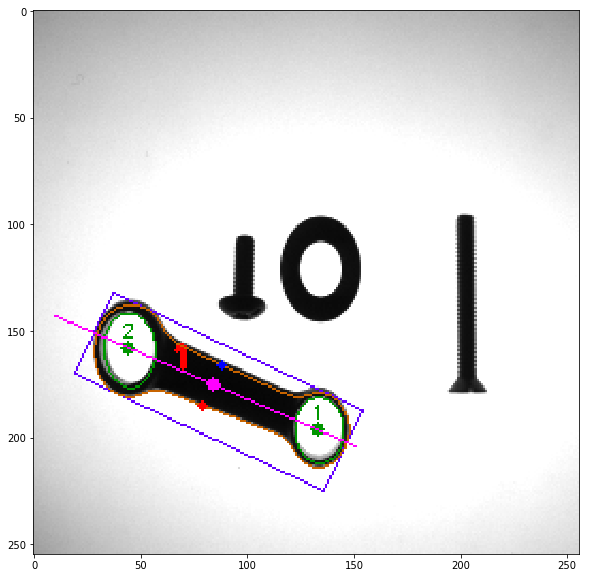

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (72, 119)
INFO:root:Area (CC): 3860
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 181.75
INFO:root:Rod Width: 44.18
INFO:root:Rod Angle (deg): 65.83°
INFO:root:Rod mass center: (75, 113)
INFO:root:Width at mass center: 17.46
INFO:root:Hole mass center: [(100, 67)]
INFO:root:Hole diameter: [29.497983932495117]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  4.97it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (130, 127)
INFO:root:Area (CC): 3737
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 162.59
INFO:root:Rod Width: 48.71
INFO:root:Rod Angle (deg): 40.55°
IN

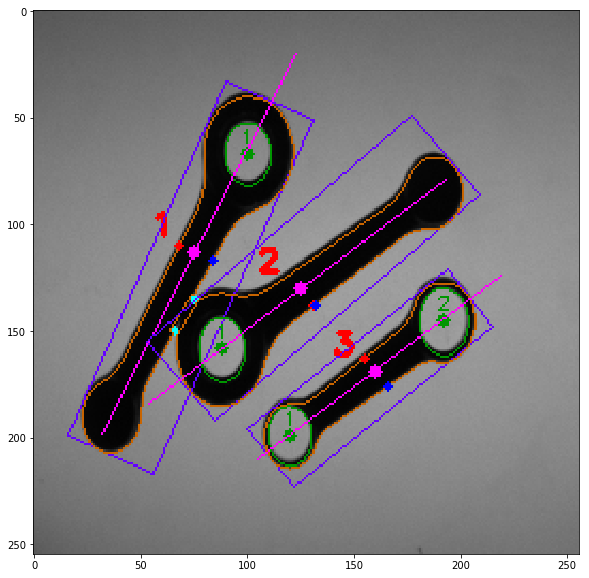

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (140, 134)
INFO:root:Area (CC): 3715
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 164.76
INFO:root:Rod Width: 47.38
INFO:root:Rod Angle (deg): 45.00°
INFO:root:Rod mass center: (135, 138)
INFO:root:Width at mass center: 1.00
INFO:root:Hole mass center: [(99, 170)]
INFO:root:Hole diameter: [31.06464958190918]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  6.24it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (90, 112)
INFO:root:Area (CC): 3723
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 153.18
INFO:root:Rod Width: 51.37
INFO:root:Rod Angle (deg): 24.57°
INF

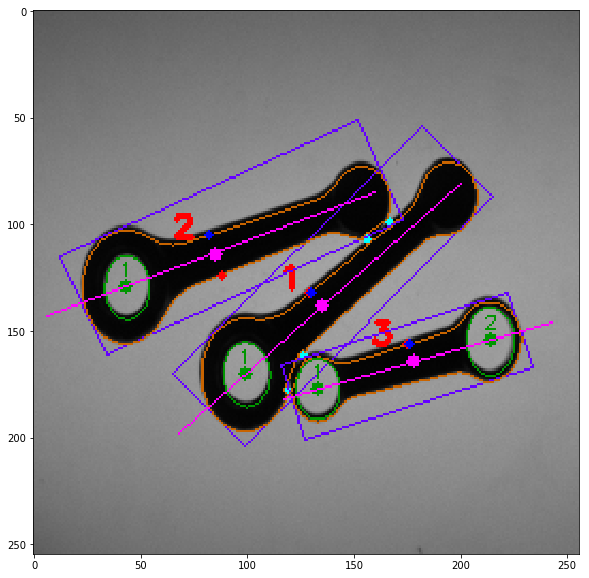

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (152, 31)
INFO:root:Area (CC): 3859
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 167.25
INFO:root:Rod Width: 47.85
INFO:root:Rod Angle (deg): 131.78°
INFO:root:Rod mass center: (156, 109)
INFO:root:Width at mass center: 19.10
INFO:root:Hole mass center: [(121, 76)]
INFO:root:Hole diameter: [29.497983932495117]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (160, 113)
INFO:root:Area (CC): 1787
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 127.22
INFO:root:Rod Width: 33.77
INFO:root:Rod Angle (deg): 126.63°

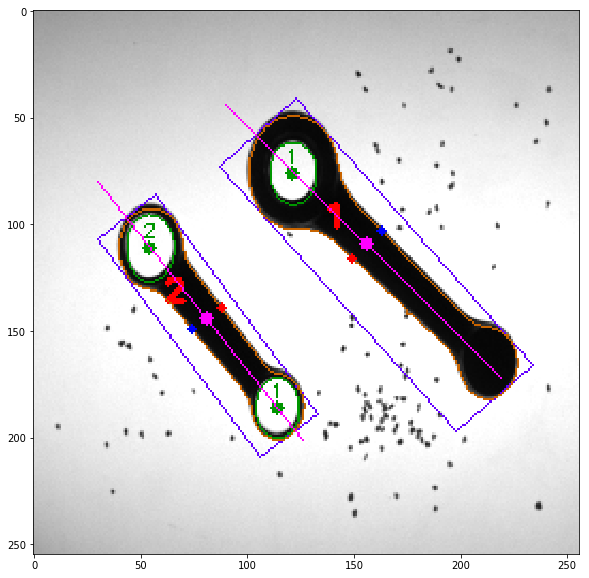

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 3
Processing rods:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (62, 99)
INFO:root:Area (CC): 3856
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 178.22
INFO:root:Rod Width: 44.65
INFO:root:Rod Angle (deg): 61.15°
INFO:root:Rod mass center: (58, 105)
INFO:root:Width at mass center: 1.00
INFO:root:Hole mass center: [(31, 149)]
INFO:root:Hole diameter: [30.26569175720215]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  33%|███▎      | 1/3 [00:00<00:00,  4.97it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (224, 27)
INFO:root:Area (CC): 1681
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 110.04
INFO:root:Rod Width: 37.30
INFO:root:Rod Angle (deg): 3.58°
INFO:ro

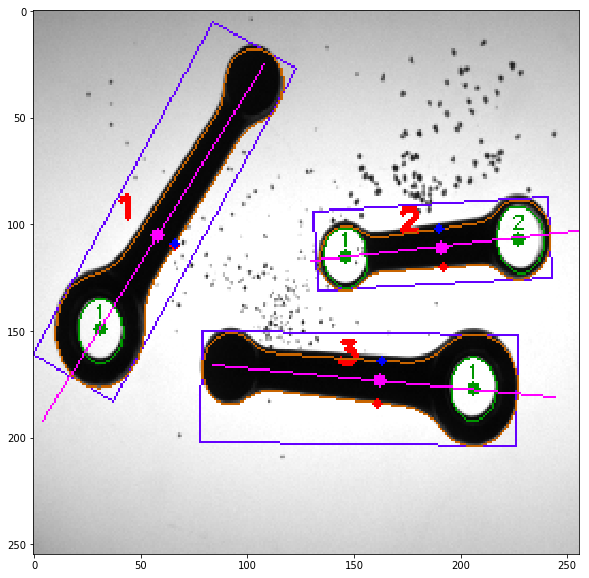

INFO:root:Gaussian filter parameters --- sigma: 1, kernel size: 7
INFO:root:Filtering rods by area...
INFO:root:Number of rods found (CC): 2
Processing rods:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:
Processing rod 1...
INFO:root:Centroid (CC): (180, 127)
INFO:root:Area (CC): 3849
INFO:root:Number of holes: 1
INFO:root:Rod type: A
INFO:root:Rod Length: 180.75
INFO:root:Rod Width: 43.75
INFO:root:Rod Angle (deg): 64.73°
INFO:root:Rod mass center: (183, 122)
INFO:root:Width at mass center: 1.00
INFO:root:Hole mass center: [(208, 75)]
INFO:root:Hole diameter: [29.6143856048584]

INFO:root:*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^*^

Processing rods:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s]INFO:root:
Processing rod 2...
INFO:root:Centroid (CC): (76, 130)
INFO:root:Area (CC): 1745
INFO:root:Number of holes: 2
INFO:root:Rod type: B
INFO:root:Rod Length: 116.20
INFO:root:Rod Width: 36.49
INFO:root:Rod Angle (deg): 147.43°
INF

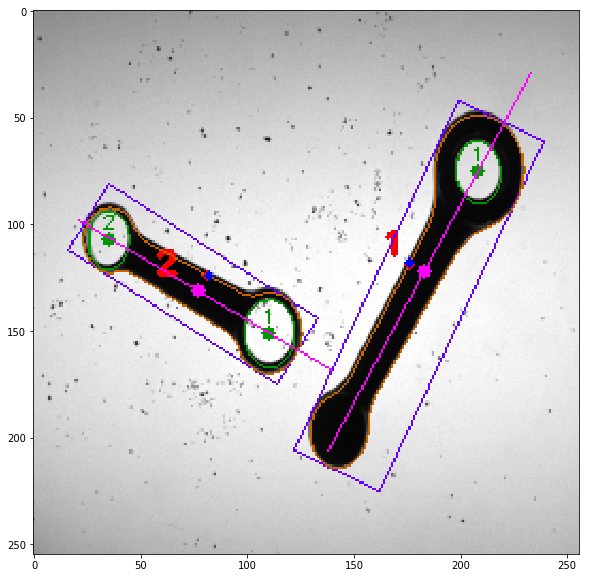

In [6]:
for i in range(9):
    rod_info = detect_rods_blob(
        images_2[i], min_area=1500, detect_contact_pts=True)